In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
data = pd.read_csv('../Data/LT_DU_ML_results.csv')
data.head()

,nace,esize_class,gender,age_class,lpk,education,experience,target,xgb,xgb_mc,grb,rf,lm,svr,voting,tf
0,C,1_49,M,40-49,p721,G2,13,8.20,4.503678,4.408886,4.176350,4.778167,4.061958,4.009178,4.390707,4.049001
1,C,1_49,F,40-49,p334,G2,0,2.51,3.051344,3.037208,2.980969,3.041897,2.992907,3.122998,3.266770,3.292751
2,M,50_249,F,40-49,p522,G2,18,2.19,3.425669,3.228116,3.172908,3.256087,3.945913,2.907824,3.278419,3.245212
3,M,50_249,F,40-49,p522,G2,12,2.19,3.298834,3.212965,3.066702,3.219982,3.849712,2.802480,3.200731,3.176937
4,M,50_249,F,14-29,p522,G2,0,2.19,2.991804,3.021976,2.920913,2.993366,3.531646,2.741929,3.123216,2.880577


# Target correlation with model prediction and distribution of residuals

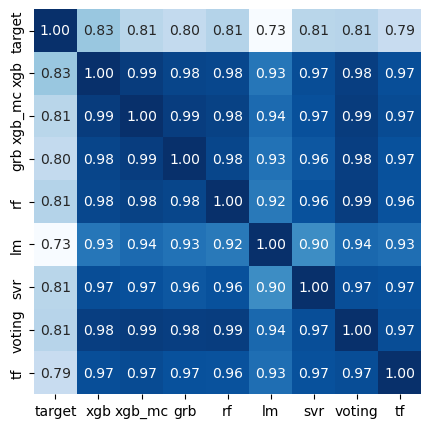

In [4]:
target_models_columns = ['target', 'xgb', 'xgb_mc', 'grb', 'rf', 'lm', 'svr', 'voting', 'tf']
plt.figure(figsize = (5, 5))
sns.heatmap(data[target_models_columns].corr(), annot=True, fmt=".2f", cmap='Blues', cbar=False);

Extreme Gradient Boosting model with one hot encoding (xgb) has highest correlation with target. Use of ordinal feature encoding does not improve the model. The worst correlation is with  Linear Regression model prediction. The corelation between different models is very strong (≥ 0.90) suggesting that all models are close to potential which can be achieved using chosen features. The regression between target and features is likely to be not linear, because linear regression model has the worst performance and weakest corelation with other models which can represent non linear relationship.

In [5]:
model_columns = ['xgb', 'xgb_mc', 'grb', 'rf', 'lm', 'svr', 'voting', 'tf']
residual_columns = [ f'{name}_residual' for name in model_columns]

residuals = data.copy()

for index, model in enumerate(model_columns):
    residuals[residual_columns[index]] = residuals[model] - residuals['target']
    
residuals.columns

Index(['nace', 'esize_class', 'gender', 'age_class', 'lpk', 'education',
       'experience', 'target', 'xgb', 'xgb_mc', 'grb', 'rf', 'lm', 'svr',
       'voting', 'tf', 'xgb_residual', 'xgb_mc_residual', 'grb_residual',
       'rf_residual', 'lm_residual', 'svr_residual', 'voting_residual',
       'tf_residual'],
      dtype='object')

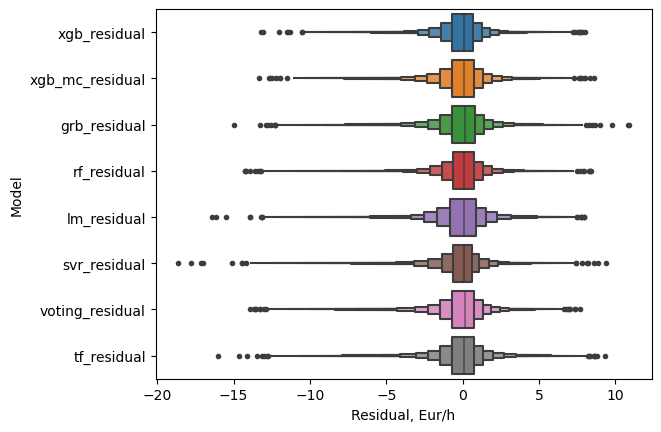

In [6]:
feature_columns = ['nace', 'esize_class', 'gender', 'age_class', 'lpk', 'education', 'experience']

residuals_long = (
    residuals.
    drop(model_columns, axis=1).
    melt(id_vars=feature_columns, value_vars=residual_columns)
)

sns.boxenplot(data=residuals_long, y='variable',x='value', flier_kws={"marker": "."})
plt.ylabel('Model')
plt.xlabel('Residual, Eur/h');

In [7]:
residuals[residual_columns].quantile([0.1, 0.9]).round(2)

,xgb_residual,xgb_mc_residual,grb_residual,rf_residual,lm_residual,svr_residual,voting_residual,tf_residual
0.1,-1.66,-1.77,-1.75,-1.63,-1.94,-1.64,-1.72,-1.70
0.9,1.44,1.51,1.57,1.52,1.78,1.30,1.49,1.55


In [8]:
number_of_negative_predictions = (data[model_columns]<=0).sum()
number_of_negative_predictions

xgb       0
xgb_mc    0
grb       0
rf        0
lm        0
svr       0
voting    0
tf        0
dtype: int64

The residuals of all models are distributed similarly. The negative residuals are larger showing that the target value can be much higher than predicted even though the extreme outliers (>= 90 percentile) are removed in preprocessing. The 80% of residuals for all models except linear regression are between -1.8 and 1.6 Eur/h. All predictions by all models are positive.

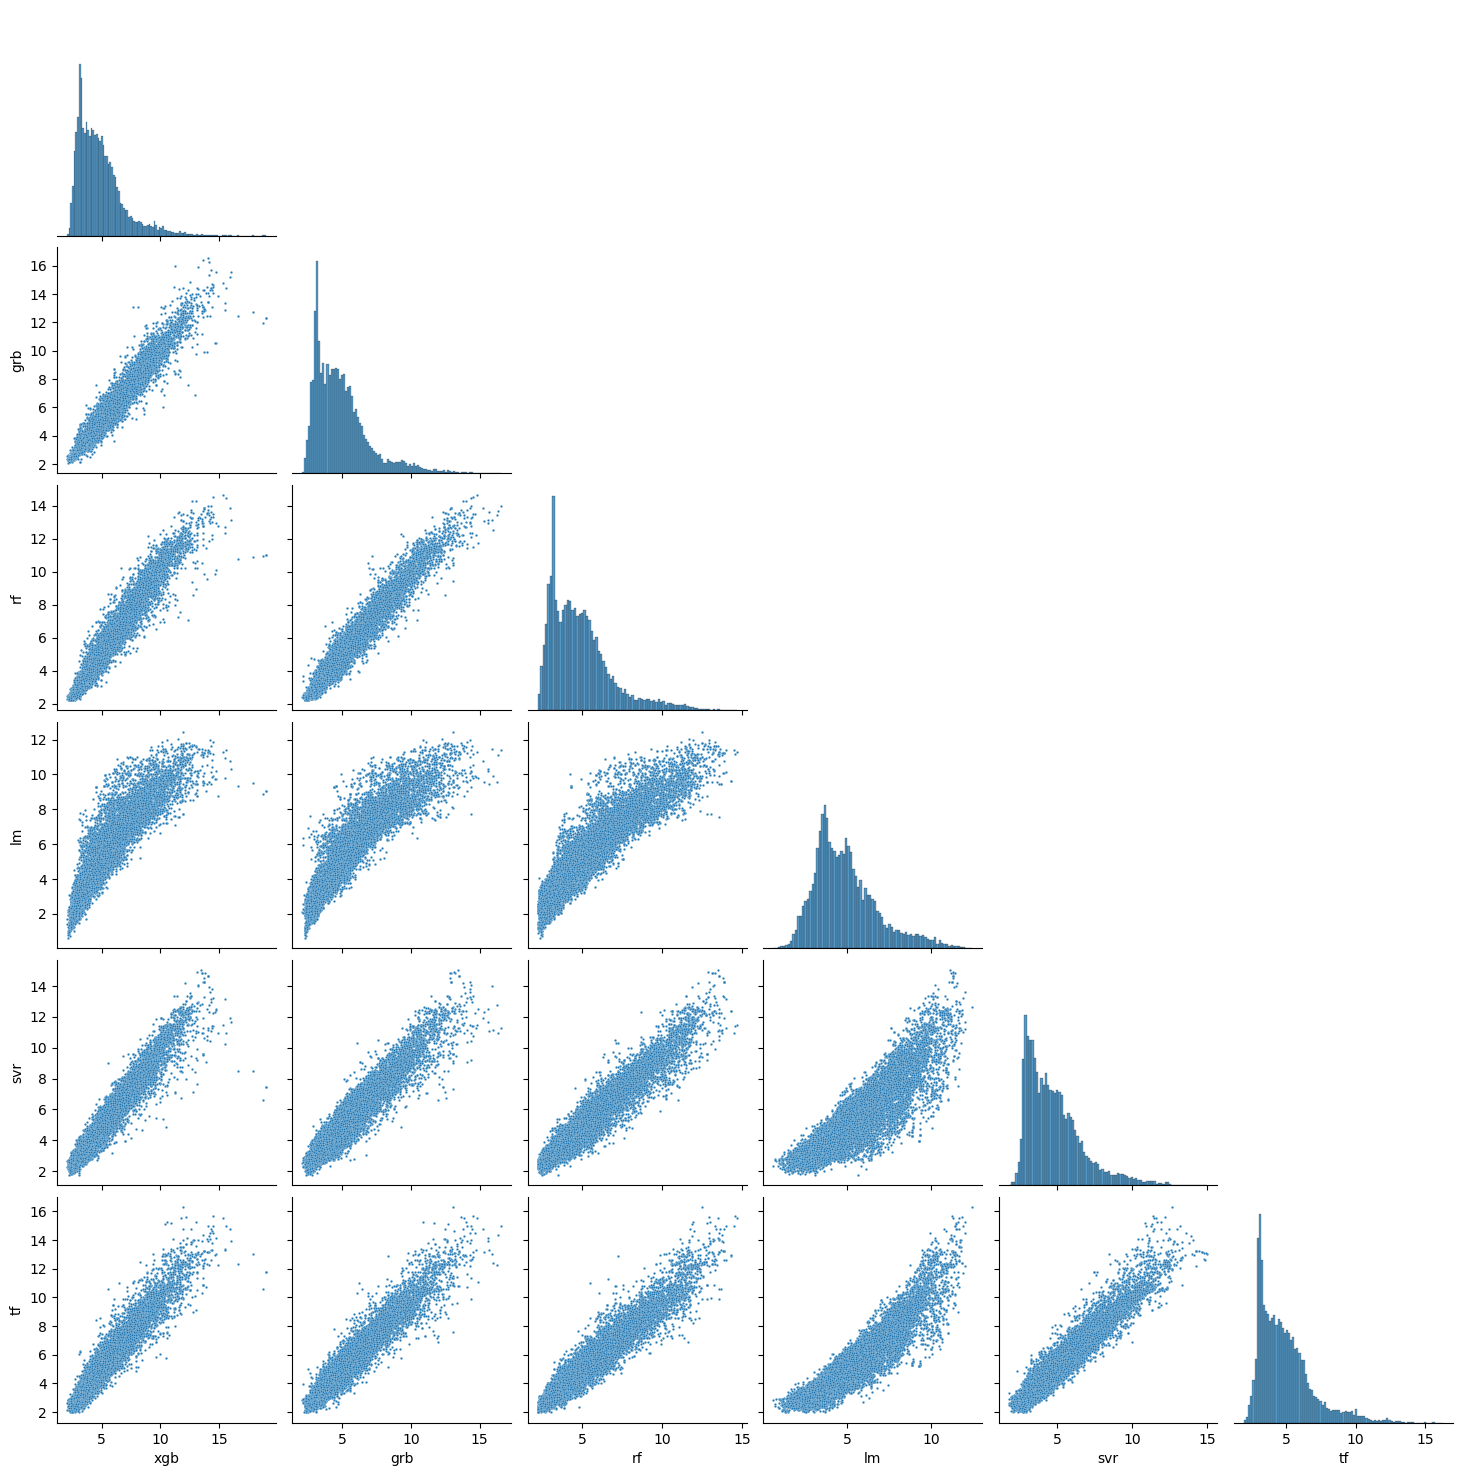

In [35]:
sns.pairplot( residuals[['xgb','grb', 'rf', 'lm', 'svr','tf']], corner=True, plot_kws={"s": 3});

# Extreme Gradient Boosting

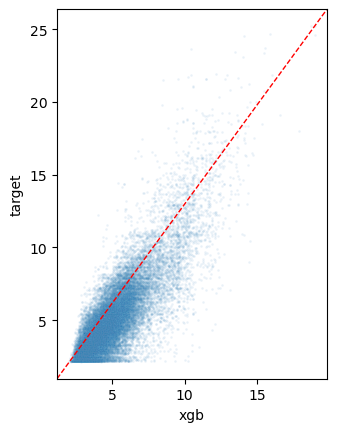

In [31]:
fig, ax = plt.subplots()
sns.scatterplot(ax=ax, data=residuals, x='xgb', y='target', s=3,alpha=0.1 )
ax.set_aspect(aspect=1, adjustable=None, anchor=None, share=False)
ax.plot((0,1), (0, 1), transform=ax.transAxes, linestyle='--', color='r', lw=1);